ES 335 Machine Learning <br>
Assignment 1
<hr>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tsfel

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Task 3 : Data Collection in the Wild [2 marks]

For this exercise marks will not depend on what numbers you get but on the process you followed Utilize apps like Physics Toolbox Suite from your smartphone to collect your data in .csv/.txt format. Ensure at least 15 seconds of data is collected, trimming edges to obtain 10 seconds of relevant data. Also record a video of yourself while recording data. This video will be required in some future assignments. Collect 3-5 samples per activity class.

<hr>

## Question 1

Use the Decision Tree model trained on the UCI-HAR dataset to predict the activities that you performed. Report the accuracy, precision, recall and confusion matrix of the model. You have three version of UCI dataset you can use a)Raw data from accelerometer, b)TSFEL featurised data, c)Features provided by author. Choose which version to use, ensuring that your test data is similar to your training data. How did the model perform? [1 marks]



### Preprocessing

For preprocessing, the data is 
* Resampled to 50Hz
* Converted to Moving Average for smoothing
* On performing EDA, axis and range mismatch was observed, hence;
  * The axises are remapped to match the orignial dataset axis. 
  * i.e. due to change in things like recording device, device orientation while recording, the data collected in Wild has different axis and range than that of UCI HAR dataset


In [2]:
# CollectedInWild\preprocess_helper.py
import CollectedInWild.preprocess_helper as preproc

In [3]:
preproc.resample_driver() # Resample and Moving Average
preproc.split_driver()    # Create Accelrometer only and Accelrometer + Gyro dataset
preproc.flip_driver()     # Transform Axis to match UCI HAR
preproc.range_driver()    # Transform Axis to match UCI HAR

Processing file: CollectedInWild\Test\LAYING\Subject_1.csv
Processing file: CollectedInWild\Test\LAYING\Subject_2.csv
Processing file: CollectedInWild\Test\LAYING\Subject_3.csv
Processing file: CollectedInWild\Test\LAYING\Subject_4.csv
Processing file: CollectedInWild\Test\LAYING\Subject_5.csv
Processing file: CollectedInWild\Test\LAYING\Subject_6.csv
Processing file: CollectedInWild\Test\SITTING\Subject_1.csv
Processing file: CollectedInWild\Test\SITTING\Subject_2.csv
Processing file: CollectedInWild\Test\SITTING\Subject_3.csv
Processing file: CollectedInWild\Test\SITTING\Subject_4.csv
Processing file: CollectedInWild\Test\SITTING\Subject_5.csv
Processing file: CollectedInWild\Test\SITTING\Subject_6.csv
Processing file: CollectedInWild\Test\STANDING\Subject_1.csv
Processing file: CollectedInWild\Test\STANDING\Subject_2.csv
Processing file: CollectedInWild\Test\STANDING\Subject_3.csv
Processing file: CollectedInWild\Test\STANDING\Subject_4.csv
Processing file: CollectedInWild\Test\STAN

### Training UCI HAR dataset preprocessing

* Feature extraction code provided is used to extract to "Combined" folder
* A slightly modified code of the code provided is used to extract both accelometer and gyroscope to "CombinedX" folder


### Plots

In [4]:
# Plothelper.py
import plotterhelper

#### UCI HAR

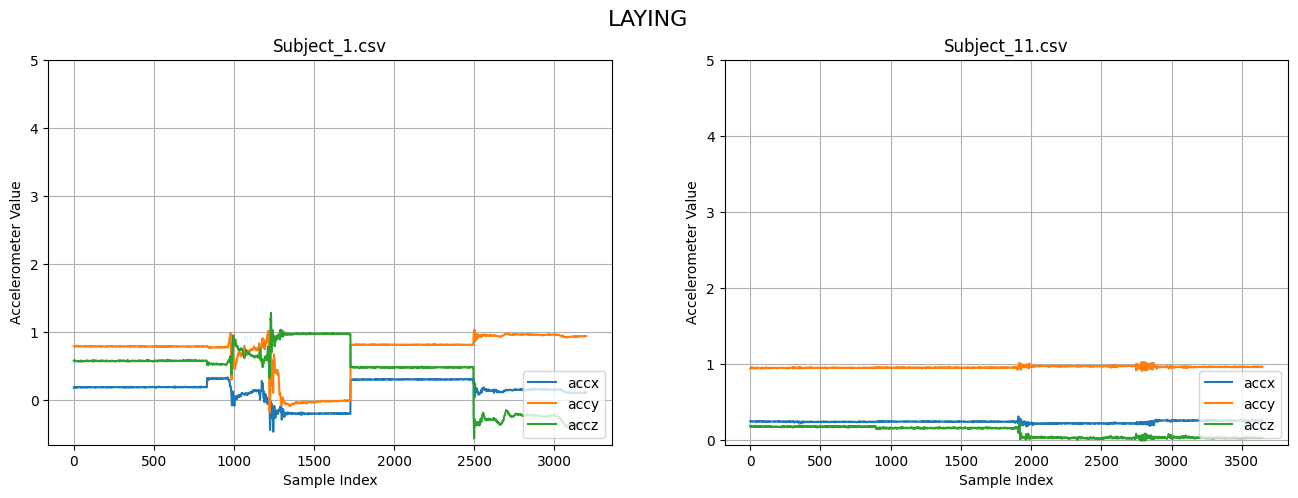

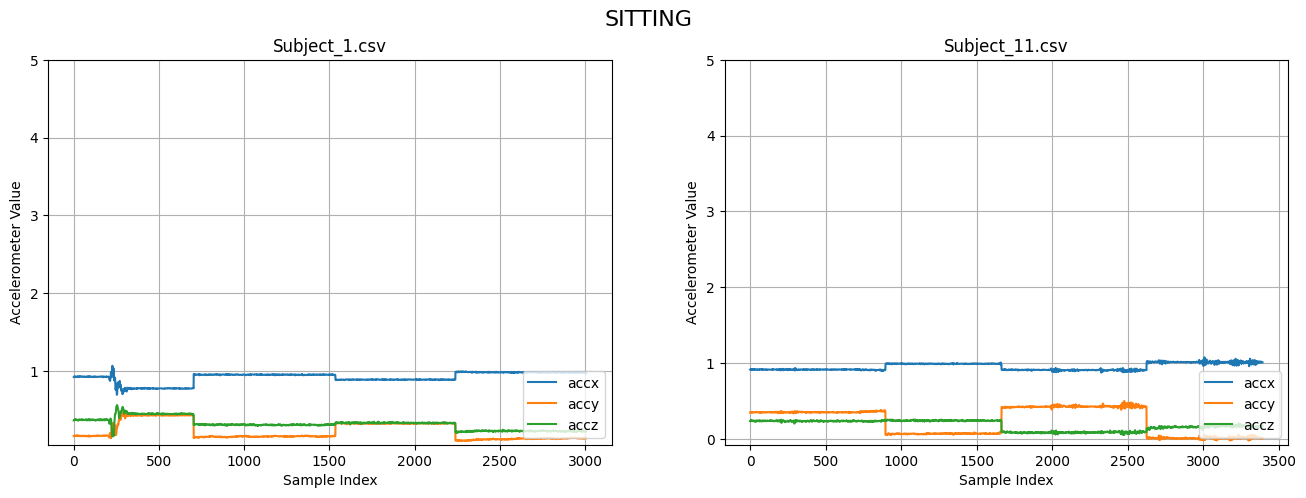

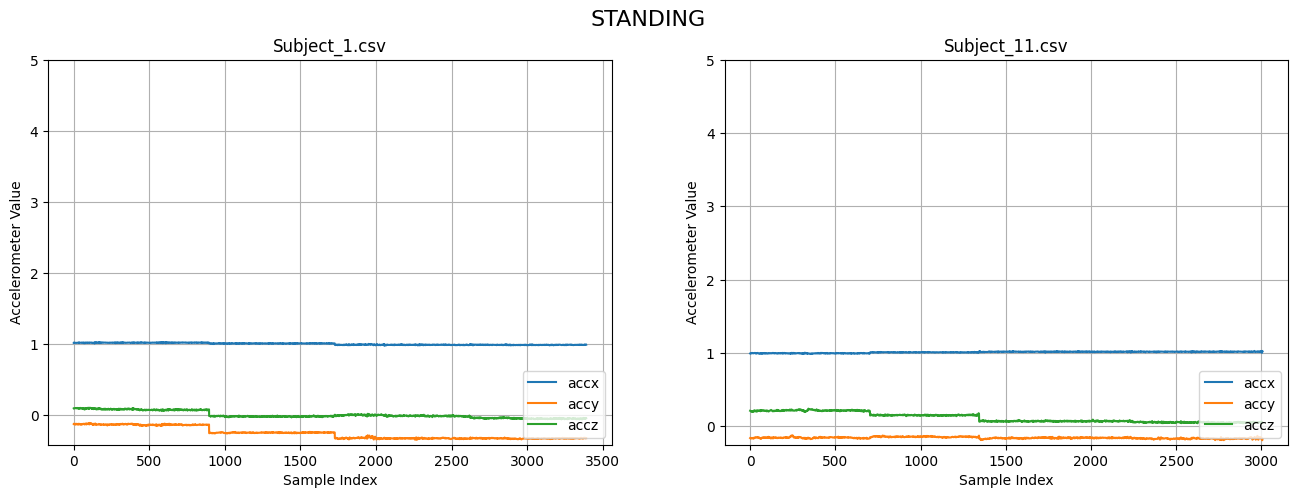

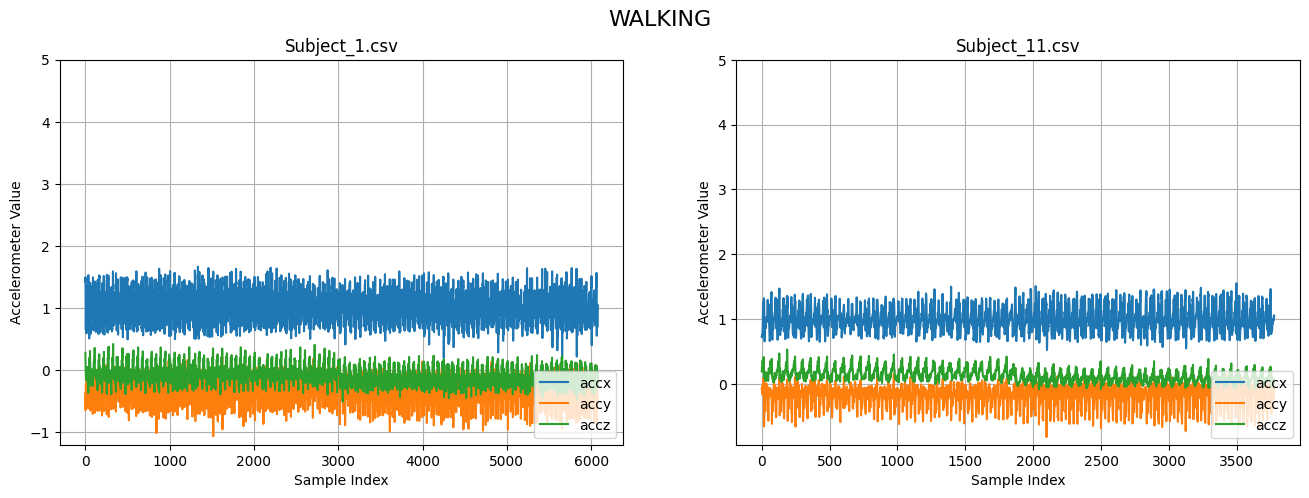

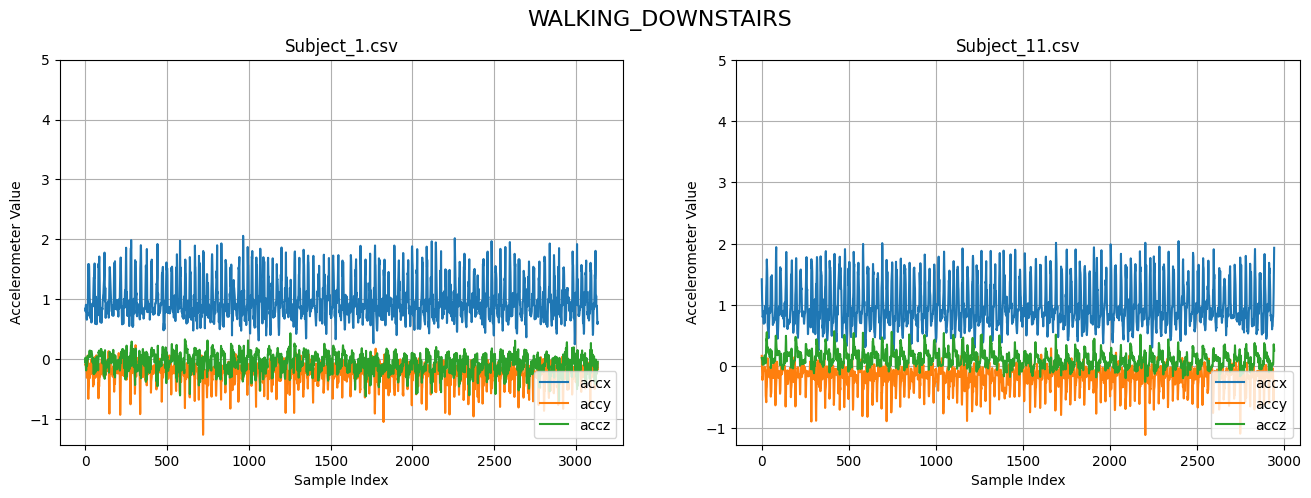

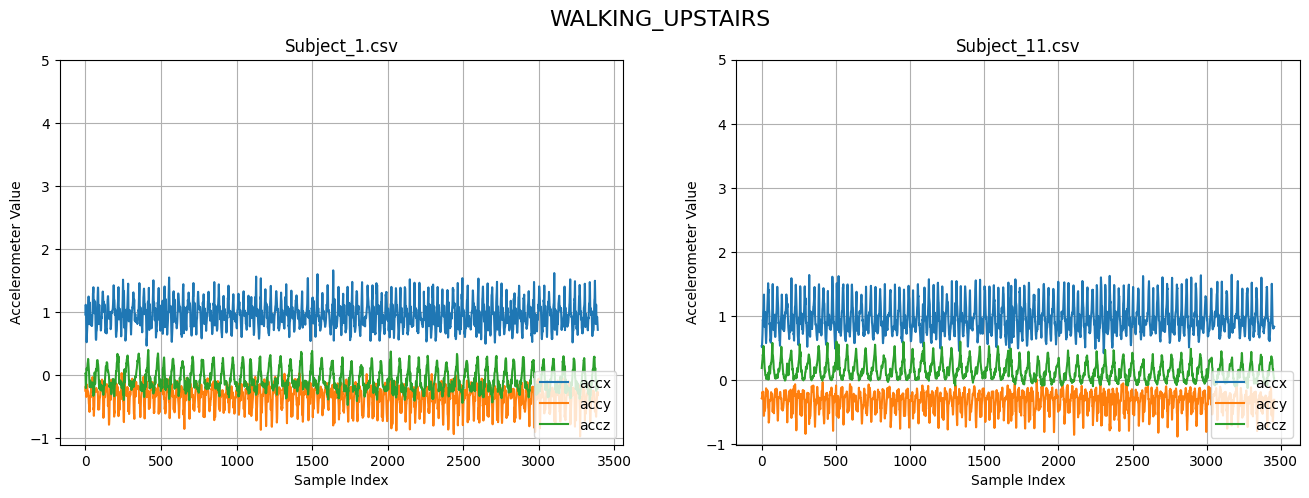

In [5]:
plotterhelper.plot_fn('.\\Combined\\Train')

#### Collected Data

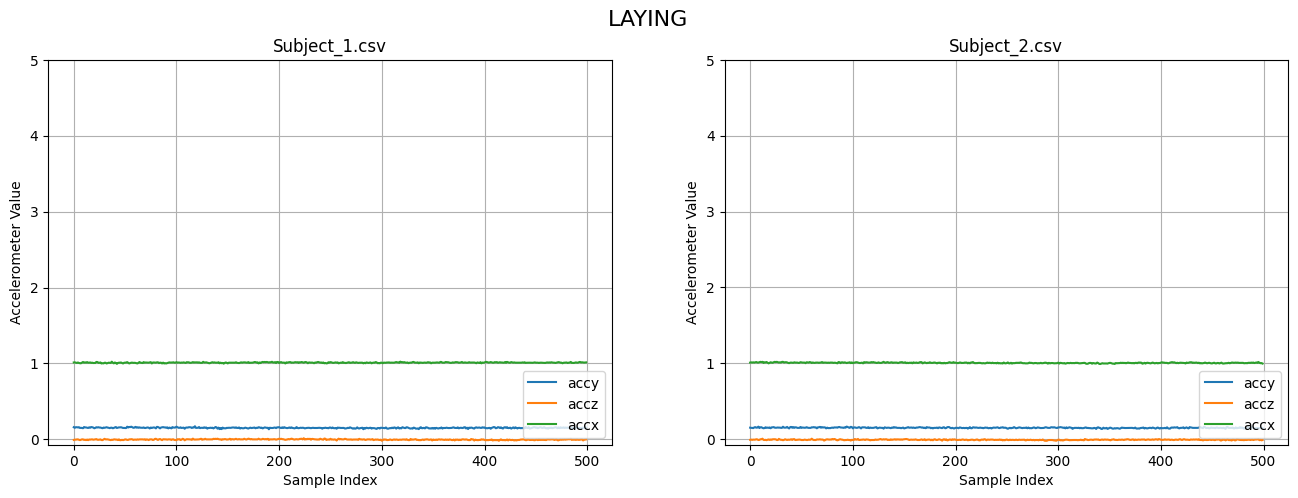

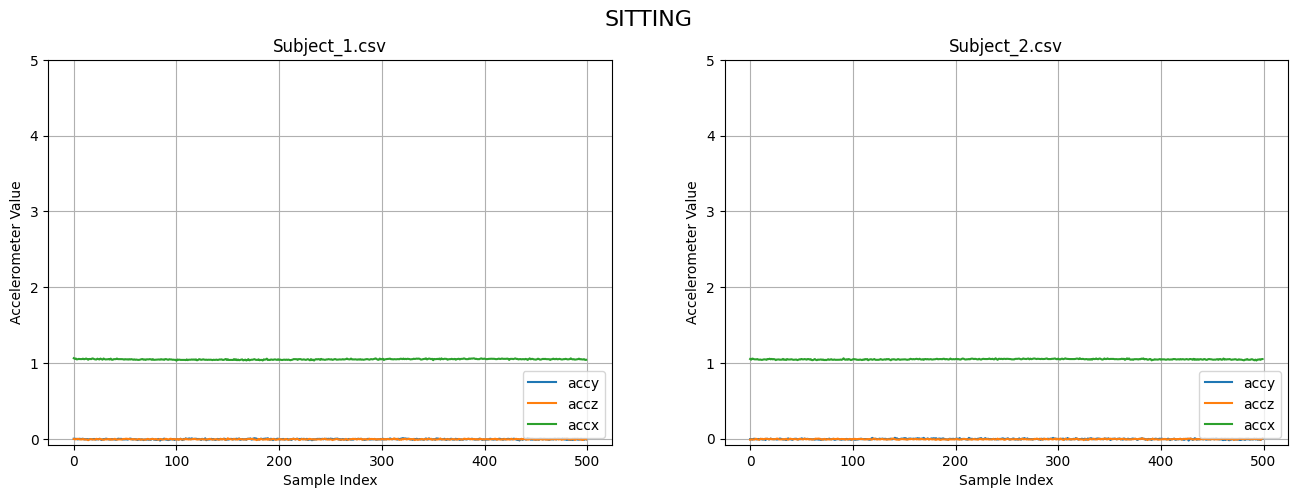

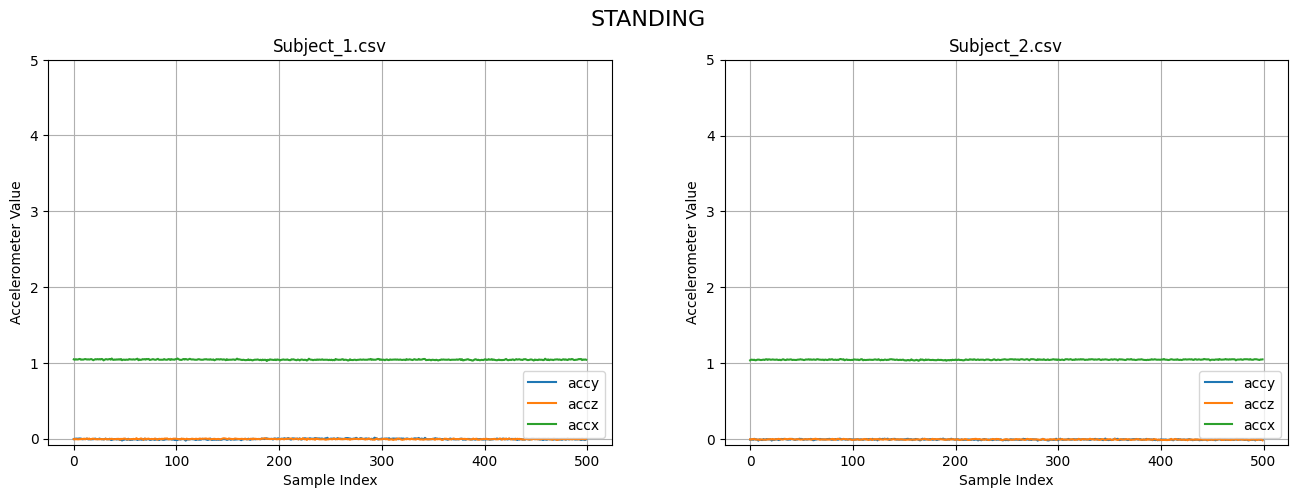

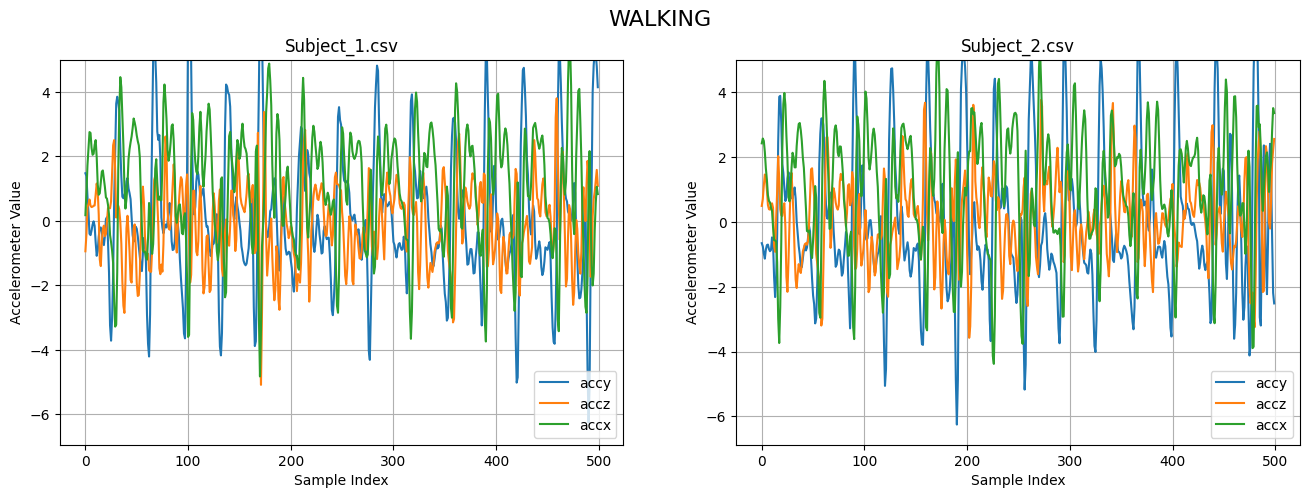

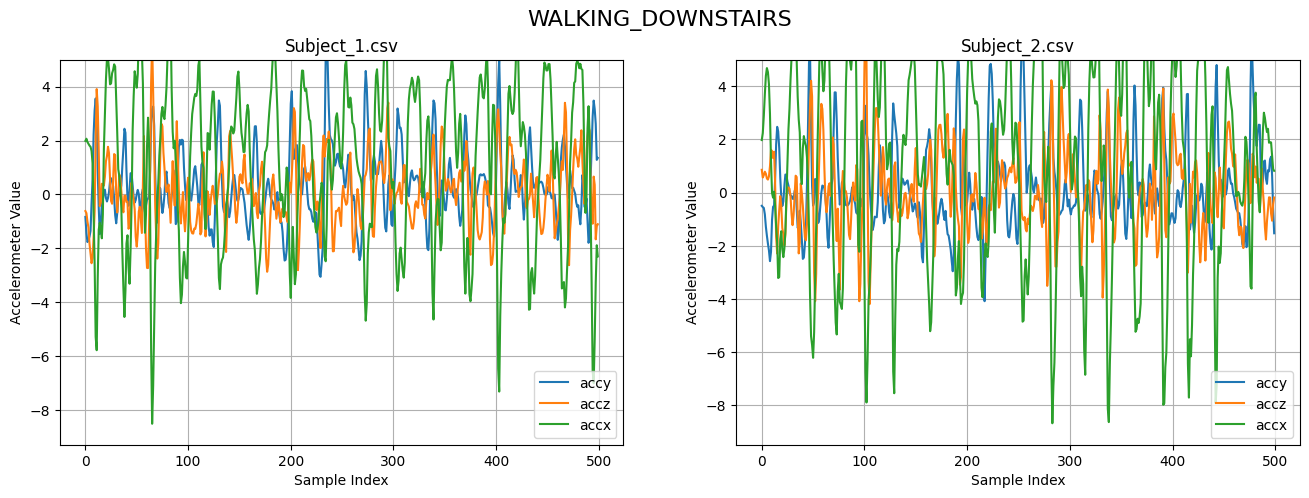

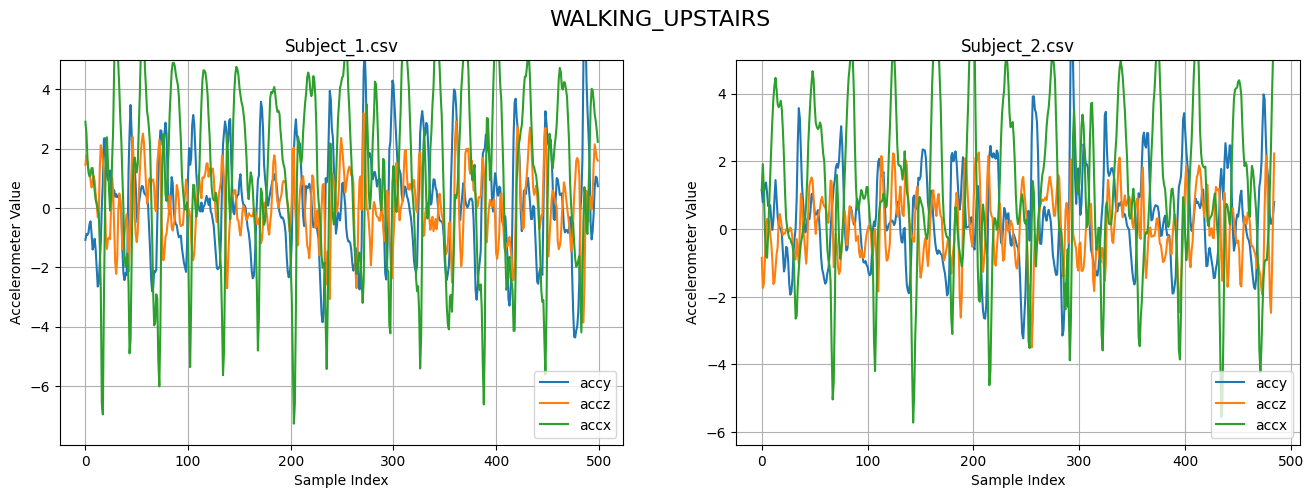

In [6]:
plotterhelper.plot_fn('.\\CollectedInWild\\TestMA50F_acc_N')

### Raw Data & TSFEL Featurized data

* TSFEL featurized data might be better as task as 
   * Features provided by authors have a large number of features collected, which has shown to have minimal performance gain in previous tasks, but would require collection of larger datas.

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tsfel
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

depths = list(range(2, 9))
ACTIVITIES = [
    "WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS",
    "SITTING", "STANDING", "LAYING"
]
TARGET_LEN = 256

In [ ]:
def resampleL(arr_1d, target_len):

    n = len(arr_1d)
    if n == target_len:
        return arr_1d
    x_old = np.linspace(0, 1, n)
    x_new = np.linspace(0, 1, target_len)
    return np.interp(x_new, x_old, arr_1d)

def resample2D(arr_2d, target_len):

    T, C = arr_2d.shape
    out = np.zeros((target_len, C), dtype=float)
    for c in range(C):
        out[:, c] = resampleL(arr_2d[:, c], target_len)
    return out

def readfile(path):

    df = pd.read_csv(path, sep=",")
    # if df.shape[1] == 1:
    #     col0 = df.iloc[:, 0].astype(str)
    #     if col0.str.contains(",").any():
    #         df = col0.str.split(",", expand=True)

    # df = df.apply(pd.to_numeric, errors="coerce").dropna(how="any")

    if df.shape[1] < 6:
        for _ in range(6 - df.shape[1]):
            df[df.shape[1]] = 0.0

    return df.iloc[:, :6].values


def loadCF(base_path, target_len=256):

    X, y = [], []
    for act in ACTIVITIES:
        folder = os.path.join(base_path, act)
        for f in sorted(os.listdir(folder)):
            if not f.lower().endswith((".txt", ".csv")):
                continue
            arr = readfile(os.path.join(folder, f))
            if arr.shape[0] < 5:
                continue
            arr_rs = resample2D(arr, target_len)
            X.append(arr_rs.flatten())
            y.append(act)
    return np.vstack(X), np.array(y)

def extract_tsfel_matrix(X_flat):
    cfg = tsfel.get_features_by_domain()
    feats_list = []

    T6 = X_flat.shape[1] // 6
    for i in range(X_flat.shape[0]):

        arr = X_flat[i].reshape(T6, 6)

        df = pd.DataFrame(arr, columns=["accx", "accy", "accz", "gyrox", "gyroy", "gyroz"])

        feats = tsfel.time_series_features_extractor(cfg, df, fs=50, verbose=0)
        feats_list.append(feats.values.flatten())
    return np.vstack(feats_list)

def sweep(Xtr, ytr, Xte, yte, label):

    accs = []
    for d in depths:
        clf = DecisionTreeClassifier(max_depth=d, random_state=42)
        clf.fit(Xtr, ytr)
        pred = clf.predict(Xte)
        accs.append(accuracy_score(yte, pred))
    print(f"{label} accuracies:", ["{:.3f}".format(a) for a in accs])
    return accs


def plot(clf, X_test, y_test, title_prefix=""):

    y_pred = clf.predict(X_test)


    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}  ")
    print(f"Recall:    {recall:.4f}  ")


    cm = confusion_matrix(y_test, y_pred, labels=ACTIVITIES)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=ACTIVITIES, yticklabels=ACTIVITIES)
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()


def best(accs):

    if not accs: return (None, None)
    i = int(np.argmax(accs))
    return depths[i], accs[i]

#### ACCELEROMETER ONLY

[Raw] Loading Combined/Train and Combined/Test ...

[Sweep] Raw Accel ...
Raw accuracies: ['0.364', '0.455', '0.455', '0.364', '0.455', '0.455', '0.455']

=== Best depth per method (by test accuracy) ===
Raw Accel:   depth=3,  acc=0.4545

--- Detailed Metrics for Best Raw Model (depth=3) ---
Accuracy:  0.4545
Precision: 0.2545 (weighted)
Recall:    0.4545 (weighted)


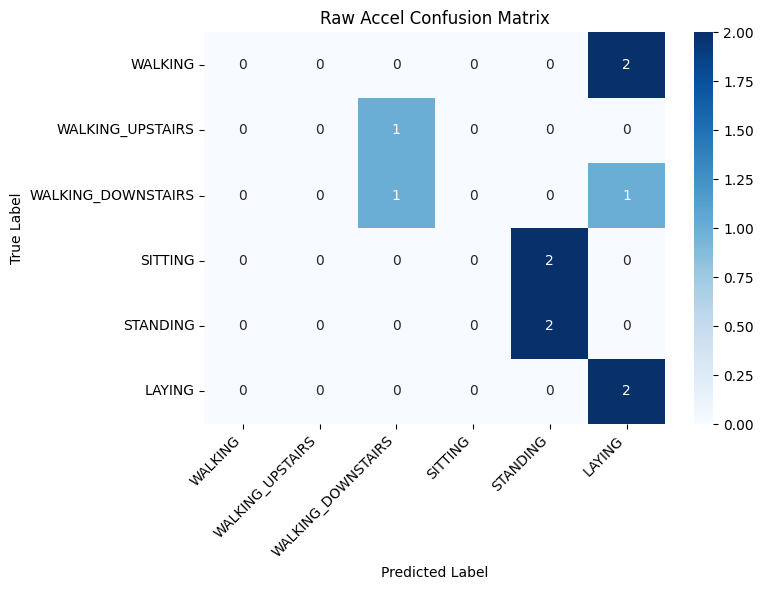

In [9]:
COMBINED_TRAIN = os.path.join(".", "Combined", "Train")
COMBINED_TEST = os.path.join(".", "WildTest", "")


print("[Raw] Loading Combined/Train and Combined/Test ...")
Xtr_raw, ytr_raw = loadCF(COMBINED_TRAIN, TARGET_LEN)
Xte_raw, yte_raw = loadCF(COMBINED_TEST,  TARGET_LEN)

depths = list(range(2, 9))

print("\n[Sweep] Raw Accel ...")
acc_raw = sweep(Xtr_raw, ytr_raw, Xte_raw, yte_raw, "Raw")

d_raw, b_raw = best(acc_raw)

print("\n=== Best depth per method (by test accuracy) ===")
print(f"Raw Accel:   depth={d_raw},  acc={b_raw:.4f}")


print("\n--- Detailed Metrics for Best Raw Model (depth={}) ---".format(d_raw))
best_clf_raw = DecisionTreeClassifier(max_depth=d_raw, random_state=42)
best_clf_raw.fit(Xtr_raw, ytr_raw)
plot(best_clf_raw, Xte_raw, yte_raw, "Raw Accel")

plt.show()

#### ACC + GYRO

[Raw] Loading Combined/Train and Combined/Test ...

[TSFEL] Extracting TSFEL features (train)...
[TSFEL] Extracting TSFEL features (test)...

[Sweep] TSFEL ...
TSFEL accuracies: ['0.545', '0.545', '0.545', '0.545', '0.545', '0.545', '0.545']

=== Best depth per method (by test accuracy) ===
TSFEL:              depth=2,  acc=0.5455

--- Detailed Metrics for Best TSFEL Model (depth=2) ---
Accuracy:  0.5455
Precision: 0.3455 (weighted)
Recall:    0.5455 (weighted)


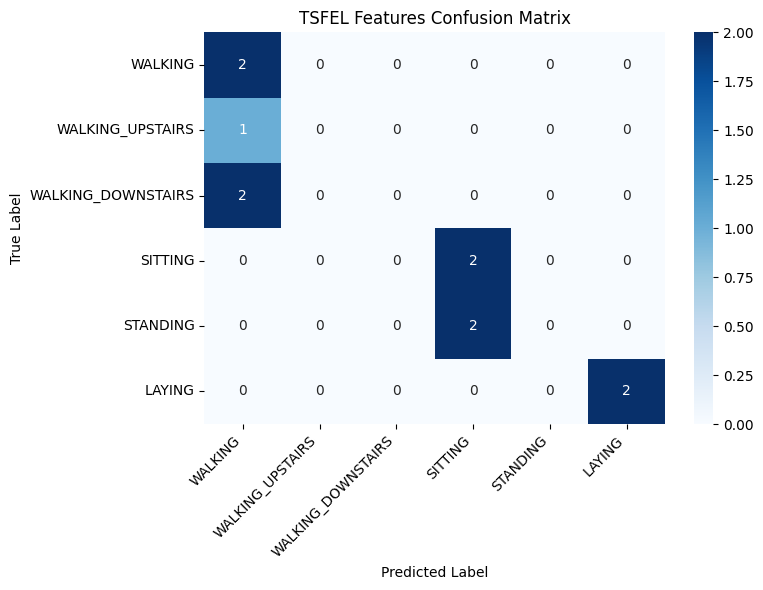

In [10]:
COMBINED_TRAIN = os.path.join(".", "CombinedX", "Train")
COMBINED_TEST  = os.path.join(".", "CombinedX", "Test")
WILD_TEST      = os.path.join(".", "WildTest", "")
WILD_TRAIN      = os.path.join(".", "WildTrain", "")

COMBINED_TEST = WILD_TEST
# COMBINED_TRAIN = WILD_TRAIN


print("[Raw] Loading Combined/Train and Combined/Test ...")
Xtr_raw, ytr_raw = loadCF(COMBINED_TRAIN, TARGET_LEN)
Xte_raw, yte_raw = loadCF(COMBINED_TEST,  TARGET_LEN)

print("\n[TSFEL] Extracting TSFEL features (train)...")
Xtr_tsfel = extract_tsfel_matrix(Xtr_raw)
print("[TSFEL] Extracting TSFEL features (test)...")
Xte_tsfel = extract_tsfel_matrix(Xte_raw)

depths = list(range(2, 9))

print("\n[Sweep] TSFEL ...")
acc_tsfel = sweep(Xtr_tsfel, ytr_raw, Xte_tsfel, yte_raw, "TSFEL")

d_raw, b_raw = best(acc_raw)
d_tsf, b_tsf = best(acc_tsfel)

print("\n=== Best depth per method (by test accuracy) ===")
print(f"TSFEL:              depth={d_tsf},  acc={b_tsf:.4f}")


print("\n--- Detailed Metrics for Best TSFEL Model (depth={}) ---".format(d_tsf))
best_clf_tsfel = DecisionTreeClassifier(max_depth=d_tsf, random_state=42)
best_clf_tsfel.fit(Xtr_tsfel, ytr_raw)
plot(best_clf_tsfel, Xte_tsfel, yte_raw, "TSFEL Features")


plt.show()

## Question 2

Use the data you collected to predict the activities that you performed. Decide whether to apply preprocessing and featurization, and if so, choose the appropriate methods. How did the model perform? [1 marks]

For preprocessing, the data is 
* Resampled to 50Hz
* Converted to Moving Average for smoothing
* On performing EDA, axis and range mismatch was observed, hence;
  * The axises are remapped to match the orignial dataset axis. 
  * i.e. due to change in things like recording device, device orientation while recording, the data collected in Wild has different axis and range than that of UCI HAR dataset


For Featurization,

* TSFEL is used

Model Performance:
*   Model performs well when the train and test dataset is collected by same device in same condition

Accuracy:  0.8182<br>
Precision: 0.8939<br>
Recall:    0.8182

[Raw] Loading Combined/Train and Combined/Test ...

[TSFEL] Extracting TSFEL features (train)...
[TSFEL] Extracting TSFEL features (test)...

[Sweep] TSFEL ...
TSFEL accuracies: ['0.455', '0.636', '0.727', '0.818', '0.818', '0.818', '0.818']

=== Best depth per method (by test accuracy) ===
TSFEL:              depth=5,  acc=0.8182

--- Detailed Metrics for Best TSFEL Model (depth=5) ---
Accuracy:  0.8182
Precision: 0.8939 (weighted)
Recall:    0.8182 (weighted)


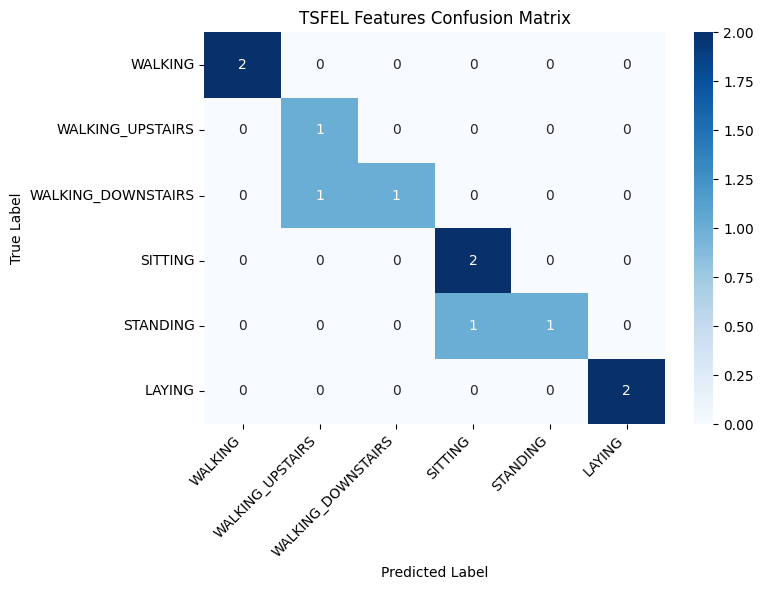

In [11]:
COMBINED_TRAIN = os.path.join(".", "CombinedX", "Train")
COMBINED_TEST  = os.path.join(".", "CombinedX", "Test")
WILD_TEST      = os.path.join(".", "WildTest", "")
WILD_TRAIN      = os.path.join(".", "WildTrain", "")

COMBINED_TEST = WILD_TEST
COMBINED_TRAIN = WILD_TRAIN


print("[Raw] Loading Combined/Train and Combined/Test ...")
Xtr_raw, ytr_raw = loadCF(COMBINED_TRAIN, TARGET_LEN)
Xte_raw, yte_raw = loadCF(COMBINED_TEST,  TARGET_LEN)

print("\n[TSFEL] Extracting TSFEL features (train)...")
Xtr_tsfel = extract_tsfel_matrix(Xtr_raw)
print("[TSFEL] Extracting TSFEL features (test)...")
Xte_tsfel = extract_tsfel_matrix(Xte_raw)

depths = list(range(2, 9))

print("\n[Sweep] TSFEL ...")
acc_tsfel = sweep(Xtr_tsfel, ytr_raw, Xte_tsfel, yte_raw, "TSFEL")

d_raw, b_raw = best(acc_raw)
d_tsf, b_tsf = best(acc_tsfel)

print("\n=== Best depth per method (by test accuracy) ===")
print(f"TSFEL:              depth={d_tsf},  acc={b_tsf:.4f}")


print("\n--- Detailed Metrics for Best TSFEL Model (depth={}) ---".format(d_tsf))
best_clf_tsfel = DecisionTreeClassifier(max_depth=d_tsf, random_state=42)
best_clf_tsfel.fit(Xtr_tsfel, ytr_raw)
plot(best_clf_tsfel, Xte_tsfel, yte_raw, "TSFEL Features")


plt.show()